In [1]:
# %%
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.tree_evaluator import TreeEvaluator

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi/2, 0])

cfg = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.1,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

In [5]:
def take_time_sign(grandchild):
    """
    Извлекает слово после последнего подчеркивания из поля 'name' каждого внука.
    Возвращает список этих слов.
    """
    
    name = grandchild['name']
    match = re.search(r'_([^_]+)$', name)
    if match.group(1) == 'forward':
        return 1
    elif match.group(1) == 'backward':
        return -1
    else:
        raise ValueError(f"Неизвестный знак времени: {match}")

# take_time_sign(grandchildren[1])

# %%

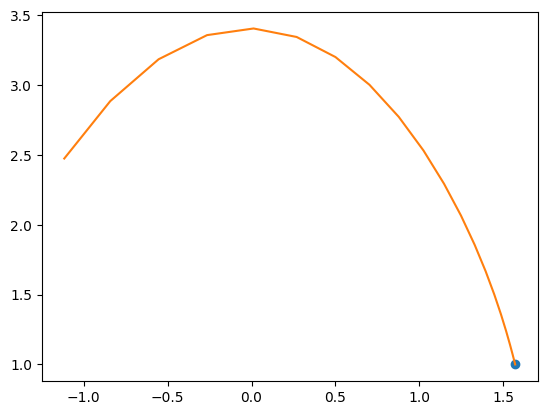

In [6]:
def draw_quad(state, time_sign,control, control_dot=0, N = 10, max_dt=0.1):
    quad_poses = [state]

    time = np.linspace(0, max_dt, N+1)
    for i in range(1,N+1):
        quad_poses.append(pendulum.quad_step(quad_poses[-1], control, 0, time_sign*time[i]))
        
    return np.array(quad_poses)


init_state = np.array([np.pi/2, 1])
poses = draw_quad(
            state=init_state, 
            control=1, 
            control_dot=0, 
            time_sign=-1,
            max_dt=0.1,
            N=20)

plt.plot(init_state[0], init_state[1], 'o')
plt.plot(poses[:, 0], poses[:, 1])
plt.show()



In [41]:
children[1]

{'position': array([1.54869822, 0.44267987]),
 'id': 'child_1',
 'name': 'back_max',
 'parent_idx': None,
 'control': 2.0,
 'dt': -0.1,
 'color': '#9B59B6',
 'size': 80,
 'child_idx': 1}

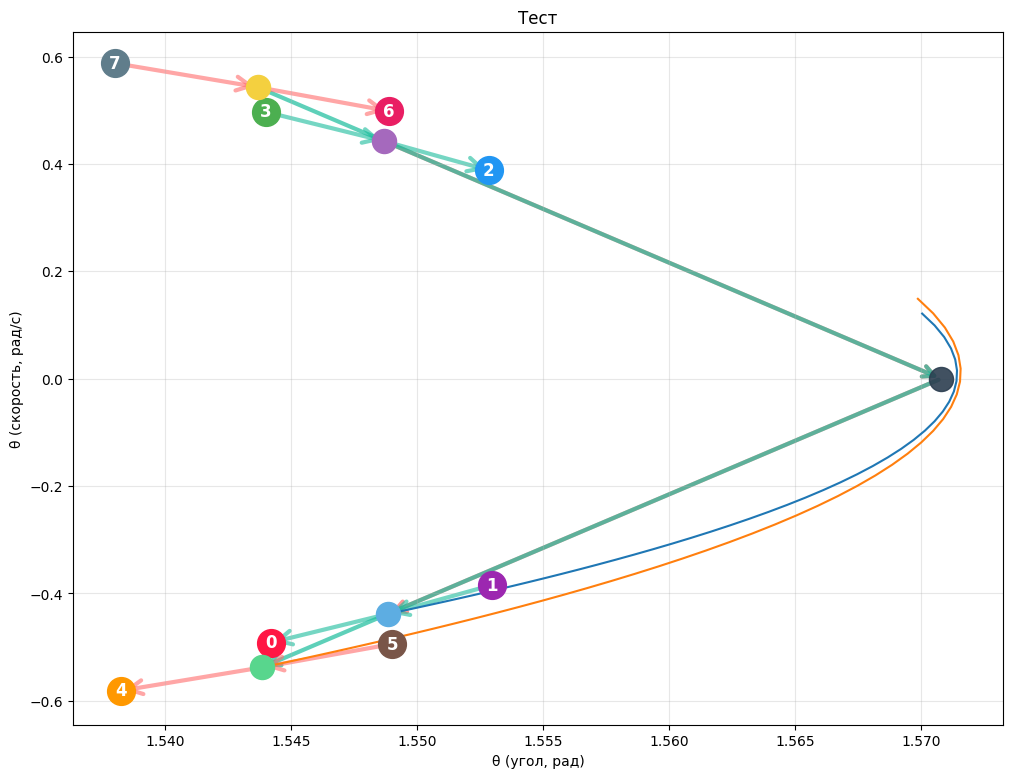

In [87]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")





i1 = 0
i2 = 2
time_signs = [-1, -1]
dt = 0.005
poses_1 = draw_quad(state=children[i1]['position'], time_sign=time_signs[0], control=children[i1]['control'], N=50, max_dt=dt)
poses_2 = draw_quad(state=children[i2]['position'], time_sign=time_signs[1], control=children[i2]['control'], N=50, max_dt=dt)
plt.plot(poses_1[:, 0], poses_1[:, 1])
plt.plot(poses_2[:, 0], poses_2[:, 1])


i = 1
# plt.plot(intersections['0 2'][i]['point'][0], intersections['0 2'][i]['point'][1], 'o')
# i = 2
# plt.plot(children[i]['position'][0], children[i]['position'][1], 'o', markersize=30, label='children[0]', zorder=10)
# plt.legend()

In [84]:
from itertools import combinations

intersections = {}
for i1, i2 in combinations(range(len(children)), 2):
    pair_intersections = pendulum.find_all_quadratic_intersections(
        state1=children[i1]['position'],
        control1=children[i1]['control'],
        state2=-children[i2]['position'],
        control2=children[i2]['control'],
    )
    intersections[f'{i1} {i2}'] = pair_intersections

print(intersections['0 2'][1])

{'t1': 0.7486780670492529, 't2': -0.97489844097863, 'point': array([-1.21056879e-03, -3.70250478e+00]), 'theta': -0.0012105687926683428, 'omega': -3.702504781185489}


In [64]:
i1 = 1
i2 = 3
print(children[0]['position'], children[0]['control'])
print(children[1]['position'], children[1]['control'])
print(children[2]['position'], children[2]['control'])
print(children[3]['position'], children[3]['control'])

intersections = pendulum.find_all_quadratic_intersections(
    state1=children[i1]['position'],
    control1=children[i1]['control'],
    state2=-children[i2]['position'],
    control2=children[i2]['control'],
)
    

[ 1.54884506 -0.43827533] 2.0
[1.54869822 0.44267987] 2.0
[ 1.54386193 -0.53776208] -2.0
[1.54368176 0.54316638] -2.0


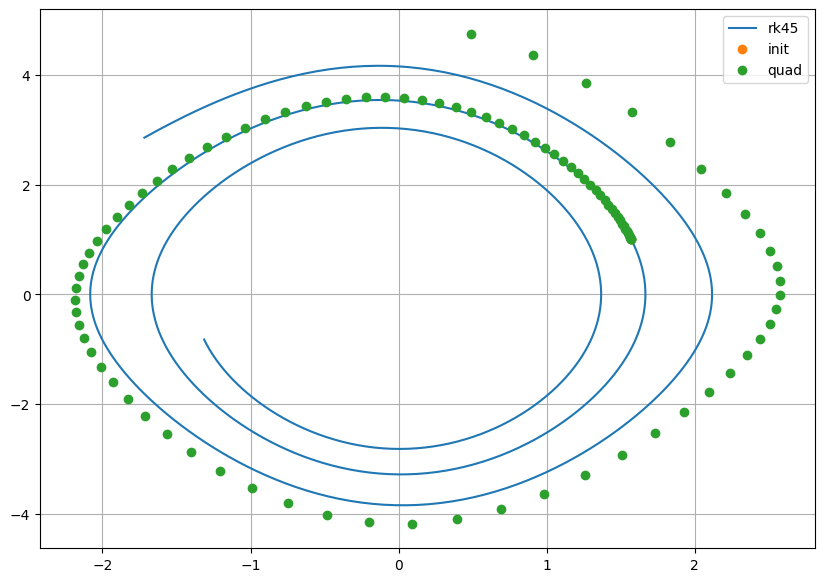

In [9]:
init_position = np.array([np.pi/2, 1])

vary_dt_poses = [init_position]
rk45_poses = [init_position]
quad_poses = [init_position]

N = 500
dt = 0.01
u = -1
u_dot = 0

for i in range(-N, N):
    next_position = pendulum.step(init_position, u, i*dt)
    vary_dt_poses.append(next_position)

for i in range(N):
    rk45_poses.append(pendulum.scipy_rk45_step(rk45_poses[-1], u, dt))
    rk45_poses = [pendulum.scipy_rk45_step(rk45_poses[0], u, -dt)] + rk45_poses

# for i in range(N):
#     quad_poses.append(pendulum.quad_step(quad_poses[-1], u, u_dot, dt))
#     quad_poses = [pendulum.quad_step(quad_poses[0], 1, 0, -dt)] + quad_poses

vary_dt_poses = np.array(vary_dt_poses)
rk45_poses = np.array(rk45_poses)
quad_poses = np.array(draw_quad(state=init_position, time_sign=-1, control=u, N=100, max_dt=0.1))

plt.figure(figsize=(10, 7))
# plt.plot(vary_dt_poses[:, 0], vary_dt_poses[:, 1], 'o', label='vary dt')

plt.plot(rk45_poses[:, 0], rk45_poses[:, 1], label='rk45')
plt.plot(init_position[0], init_position[1], 'o', label='init')
plt.plot(quad_poses[:, 0], quad_poses[:, 1], 'o', label='quad')
plt.legend()
plt.grid()

In [10]:
error = rk45_poses - quad_poses

plt.plot(np.linalg.norm(error, axis=1))
plt.grid()

ValueError: operands could not be broadcast together with shapes (1001,2) (101,2) 

In [ ]:
# Демонстрация третьей производной маятника
print("=== Демонстрация третьей производной маятника ===")

# Тестовые состояния и управления
test_states = [
    np.array([0.0, 0.0]),      # равновесие
    np.array([np.pi/4, 0.0]),  # отклонен на 45°
    np.array([np.pi/2, 1.0]),  # отклонен на 90° с начальной скоростью
    np.array([np.pi, 0.0])     # вверх ногами
]

test_controls = [0.0, 1.0, -1.0, 2.0]  # различные управления
test_control_dots = [0.0, 0.5, -0.5]   # различные производные управления

print(f"Параметры маятника:")
print(f"  g = {pendulum.g} м/с²")
print(f"  l = {pendulum.l} м")  
print(f"  m = {pendulum.m} кг")
print(f"  damping = {pendulum.damping}")
print(f"  max_control = {pendulum.max_control}")
print()

for i, state in enumerate(test_states):
    theta, omega = state
    print(f"Состояние {i+1}: θ = {theta:.3f} рад ({np.degrees(theta):.1f}°), ω = {omega:.3f} рад/с")
    
    for u in test_controls:
        for u_dot in test_control_dots:
            # Получаем все производные
            theta_dot, theta_ddot, theta_dddot = pendulum.get_all_derivatives(state, u, u_dot)
            
            print(f"  u = {u:4.1f}, u̇ = {u_dot:4.1f} → θ̇ = {theta_dot:6.3f}, θ̈ = {theta_ddot:6.3f}, θ⃛ = {theta_dddot:6.3f}")
    print()


=== Демонстрация третьей производной маятника ===
Параметры маятника:
  g = 9.81 м/с²
  l = 2.0 м
  m = 1.0 кг
  damping = 0.1
  max_control = 2.0

Состояние 1: θ = 0.000 рад (0.0°), ω = 0.000 рад/с
  u =  0.0, u̇ =  0.0 → θ̇ =  0.000, θ̈ =  0.000, θ⃛ =  0.000
  u =  0.0, u̇ =  0.5 → θ̇ =  0.000, θ̈ =  0.000, θ⃛ =  0.125
  u =  0.0, u̇ = -0.5 → θ̇ =  0.000, θ̈ =  0.000, θ⃛ = -0.125
  u =  1.0, u̇ =  0.0 → θ̇ =  0.000, θ̈ =  0.250, θ⃛ = -0.025
  u =  1.0, u̇ =  0.5 → θ̇ =  0.000, θ̈ =  0.250, θ⃛ =  0.100
  u =  1.0, u̇ = -0.5 → θ̇ =  0.000, θ̈ =  0.250, θ⃛ = -0.150
  u = -1.0, u̇ =  0.0 → θ̇ =  0.000, θ̈ = -0.250, θ⃛ =  0.025
  u = -1.0, u̇ =  0.5 → θ̇ =  0.000, θ̈ = -0.250, θ⃛ =  0.150
  u = -1.0, u̇ = -0.5 → θ̇ =  0.000, θ̈ = -0.250, θ⃛ = -0.100
  u =  2.0, u̇ =  0.0 → θ̇ =  0.000, θ̈ =  0.500, θ⃛ = -0.050
  u =  2.0, u̇ =  0.5 → θ̇ =  0.000, θ̈ =  0.500, θ⃛ =  0.075
  u =  2.0, u̇ = -0.5 → θ̇ =  0.000, θ̈ =  0.500, θ⃛ = -0.175

Состояние 2: θ = 0.785 рад (45.0°), ω = 0.000 рад/с
  u 

=== Визуализация эволюции производных ===
Отладка размеров:
  time: 200
  states: (200, 2)
  derivatives_1: 200
  derivatives_2: 200
  derivatives_3: 200



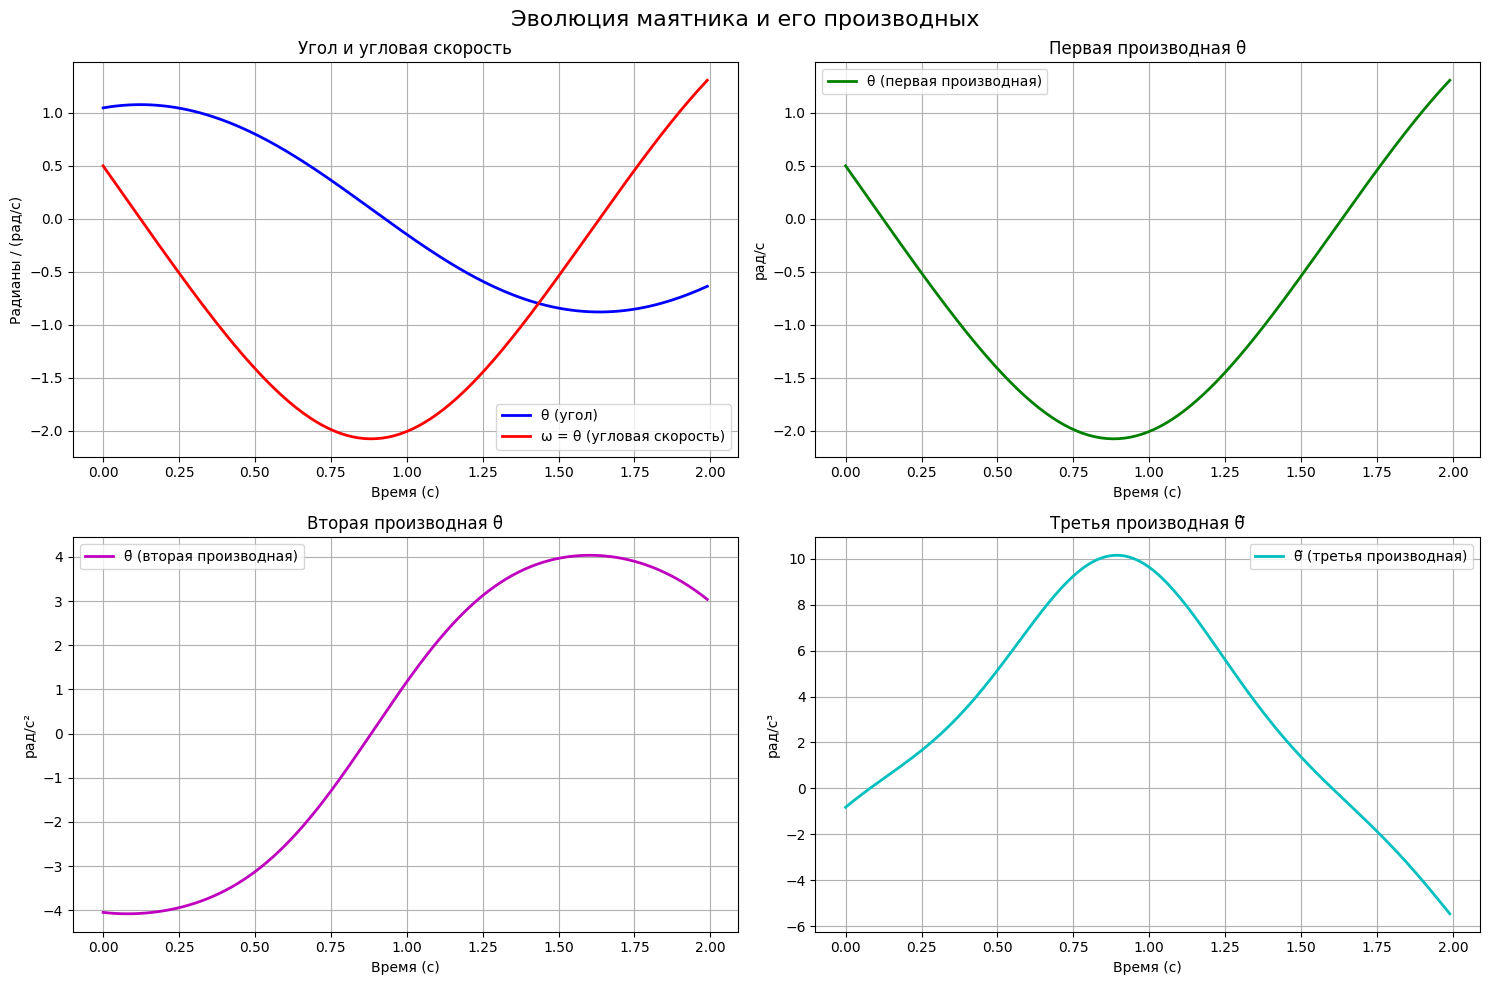

Симуляция выполнена для 200 шагов с dt = 0.01 с
Начальное состояние: θ₀ = 1.047 рад (60.0°), ω₀ = 0.500 рад/с
Управление: u = 1.0, u̇ = 0.0
Длины массивов: time=200, states=(200, 2), derivatives=200


In [ ]:
# Визуализация производных во времени
print("=== Визуализация эволюции производных ===")

# Начальное состояние и управление
initial_state = np.array([np.pi/3, 0.5])  # 60° с начальной скоростью
control = 1.0
control_dot = 0.0

# Симуляция
dt = 0.01
time_steps = 200
time = np.arange(0, time_steps) * dt  # Создаём время корректно

states = [initial_state]
derivatives_1 = []  # θ̇
derivatives_2 = []  # θ̈  
derivatives_3 = []  # θ⃛

# Симулируем time_steps шагов
for i in range(time_steps):
    current_state = states[-1]
    
    # Вычисляем все производные для текущего состояния
    d1, d2, d3 = pendulum.get_all_derivatives(current_state, control, control_dot)
    derivatives_1.append(d1)
    derivatives_2.append(d2)
    derivatives_3.append(d3)
    
    # Следующий шаг (кроме последней итерации)
    if i < time_steps - 1:
        next_state = pendulum.step(current_state, control, dt)
        states.append(next_state)

states = np.array(states)  # Конвертируем в numpy массив

# Отладочная информация
print(f"Отладка размеров:")
print(f"  time: {len(time)}")
print(f"  states: {states.shape}")
print(f"  derivatives_1: {len(derivatives_1)}")
print(f"  derivatives_2: {len(derivatives_2)}")
print(f"  derivatives_3: {len(derivatives_3)}")
print()

# Построение графиков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Эволюция маятника и его производных', fontsize=16)

# График 1: Угол и угловая скорость  
# Используем состояния для тех же временных точек, что и производные
axes[0, 0].plot(time, states[:time_steps, 0], 'b-', label='θ (угол)', linewidth=2)
axes[0, 0].plot(time, states[:time_steps, 1], 'r-', label='ω = θ̇ (угловая скорость)', linewidth=2)
axes[0, 0].set_xlabel('Время (с)')
axes[0, 0].set_ylabel('Радианы / (рад/с)')
axes[0, 0].set_title('Угол и угловая скорость')
axes[0, 0].legend()
axes[0, 0].grid(True)

# График 2: Первая производная
axes[0, 1].plot(time, derivatives_1, 'g-', label='θ̇ (первая производная)', linewidth=2)
axes[0, 1].set_xlabel('Время (с)')
axes[0, 1].set_ylabel('рад/с')
axes[0, 1].set_title('Первая производная θ̇')
axes[0, 1].legend()
axes[0, 1].grid(True)

# График 3: Вторая производная
axes[1, 0].plot(time, derivatives_2, 'm-', label='θ̈ (вторая производная)', linewidth=2)
axes[1, 0].set_xlabel('Время (с)')
axes[1, 0].set_ylabel('рад/с²')
axes[1, 0].set_title('Вторая производная θ̈')
axes[1, 0].legend()
axes[1, 0].grid(True)

# График 4: Третья производная
axes[1, 1].plot(time, derivatives_3, 'c-', label='θ⃛ (третья производная)', linewidth=2)
axes[1, 1].set_xlabel('Время (с)')
axes[1, 1].set_ylabel('рад/с³')
axes[1, 1].set_title('Третья производная θ⃛')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"Симуляция выполнена для {time_steps} шагов с dt = {dt} с")
print(f"Начальное состояние: θ₀ = {initial_state[0]:.3f} рад ({np.degrees(initial_state[0]):.1f}°), ω₀ = {initial_state[1]:.3f} рад/с")
print(f"Управление: u = {control}, u̇ = {control_dot}")
print(f"Длины массивов: time={len(time)}, states={states.shape}, derivatives={len(derivatives_1)}")
